## Bibliotecas

In [2]:
import sys
sys.path.append('../../../')
sys.path.append('../../')

In [1]:
## Spark SQL
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = (
    SparkSession
    .builder
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.driver.memory", "6g")
    .getOrCreate()
)

21/10/15 17:43:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# Spark ML
from hermione.spark import SparkSpreadsheet, SparkCleaner, SparkPreprocessor, SparkScaler, SparkVectorizer, SparkPCA, SparkCluster, SparkFS

In [4]:
# Spark ML
from hermione.base.data_source import SparkSpreadsheet, SparkCleaner, SparkPreprocessor, SparkScaler, SparkVectorizer
from hermione.base.preprocessing import SparkPreprocessor, SparkScaler, SparkVectorizer
from hermione.base.model import *
from hermione.base.analysis import SparkPCA, SparkCluster, SparkFS

In [5]:
import mlflow.pyspark.ml

## Reading Data

In [10]:
ss_source = SparkSpreadsheet(spark)

In [11]:
df = ss_source.get_data('../../../data/raw/train.csv', 'csv', header=True)

In [13]:
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [15]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



## Cleaning Data

In [16]:
cleaner = SparkCleaner(spark)

In [17]:
cleaner.clean()

In [55]:
df = ss_source.get_data('../../../data/refined/train', 'parquet')

In [56]:
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0


In [57]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- total_relatives: integer (nullable = true)



## Preprocessing

### Scaling

In [21]:
scaler = SparkScaler({'min_max': 'Age',})

In [23]:
scaler.fit(df)

<class 'hermione_spark.preprocessing._normalization.SparkScaler'>

In [24]:
scaler.transform(df).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,min_max_scaled
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,[0.275]
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,[0.47500000000000003]
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,[0.325]
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,[0.4375]
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,[0.4375]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (margaret Norton)",Female,39,0,5,382652,29.1250,None,Queenstown,5,[0.48750000000000004]
710,887,0,2,"Montvila, Rev. Juozas",Male,27,0,0,211536,13.0000,None,Southampton,0,[0.3375]
711,888,1,1,"Graham, Miss. Margaret Edith",Female,19,0,0,112053,30.0000,B42,Southampton,0,[0.23750000000000002]
712,890,1,1,"Behr, Mr. Karl Howell",Male,26,0,0,111369,30.0000,C148,Cherbourg,0,[0.325]


In [25]:
scaler = SparkScaler({'min_max': 'Age', 'zscore': ['Fare', 'total_relatives']})
scaler.fit_transform(df).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,min_max_scaled,zscore_scaled
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,[0.275],"[-0.5186143080290976, 0.0377563531260296]"
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,[0.47500000000000003],"[0.6914120587537419, 0.0377563531260296]"
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,[0.325],"[-0.505858947965218, -0.6361945501735998]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,[0.4375],"[0.3478053348284968, 0.0377563531260296]"
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,[0.4375],"[-0.5034968442496848, -0.6361945501735998]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (margaret Norton)",Female,39,0,5,382652,29.1250,None,Queenstown,5,[0.48750000000000004],"[-0.10524615781077964, 2.7335599663245476]"
710,887,0,2,"Montvila, Rev. Juozas",Male,27,0,0,211536,13.0000,None,Southampton,0,[0.3375],"[-0.4099575371145683, -0.6361945501735998]"
711,888,1,1,"Graham, Miss. Margaret Edith",Female,19,0,0,112053,30.0000,B42,Southampton,0,[0.23750000000000002],"[-0.08871143180204694, -0.6361945501735998]"
712,890,1,1,"Behr, Mr. Karl Howell",Male,26,0,0,111369,30.0000,C148,Cherbourg,0,[0.325],"[-0.08871143180204694, -0.6361945501735998]"


### Preprocessing

In [28]:
processor = SparkPreprocessor({'zscore': ['Age', 'Fare', 'total_relatives']}, ['Pclass', 'Sex'], input_strategy = 'mean')

In [29]:
processor.fit(df)

<class 'hermione_spark.preprocessing._preprocessing.SparkPreprocessor'>

In [30]:
processor.transform(df).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Pclass_ohe,Sex_ohe,zscore_scaled,features
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[-0.5797188207501821, -0.5021631365156044, 0.0...","[1.0, 0.0, 0.0, 1.0, 0.0, -0.5797188207501821,..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.6497473364373433, 0.7864036178345394, 0.059...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.6497473364373433, ..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.27235228145330076, -0.4885798515812601, -0...","[1.0, 0.0, 0.0, 0.0, 1.0, -0.27235228145330076..."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.41922243196468223, 0.4204940697654103, 0.05...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.41922243196468223,..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[0.41922243196468223, -0.4860644284452704, -0....","[1.0, 0.0, 0.0, 1.0, 0.0, 0.41922243196468223,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",Male,27,0,0,211536,13.0000,None,Southampton,0,"(0.0, 0.0, 1.0)","(1.0, 0.0)","[-0.19551064662908044, -0.38645367226007915, -...","[0.0, 0.0, 1.0, 1.0, 0.0, -0.19551064662908044..."
887,888,1,1,"Graham, Miss. Margaret Edith",Female,19,0,0,112053,30.0000,B42,Southampton,0,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[-0.8102437252228432, -0.044356125765482625, -...","[0.0, 1.0, 0.0, 0.0, 1.0, -0.8102437252228432,..."
888,889,0,3,"""johnston, Miss. Catherine Helen """"carrie""""""",Female,29,1,2,W./C. 6607,23.4500,None,Southampton,3,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.04182737698063976, -0.17616429809134188, 1...","[1.0, 0.0, 0.0, 0.0, 1.0, -0.04182737698063976..."
889,890,1,1,"Behr, Mr. Karl Howell",Male,26,0,0,111369,30.0000,C148,Cherbourg,0,"(0.0, 1.0, 0.0)","(1.0, 0.0)","[-0.27235228145330076, -0.044356125765482625, ...","[0.0, 1.0, 0.0, 1.0, 0.0, -0.27235228145330076..."


In [32]:
processor = SparkPreprocessor({'zscore': ['Age', 'Fare', 'total_relatives']}, ['Pclass', 'Sex'], input_strategy = 'mode')
processor.fit_transform(df).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Pclass_ohe,Sex_ohe,zscore_scaled,features
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[-0.49602935248113283, -0.5021631365156044, 0....","[1.0, 0.0, 0.0, 1.0, 0.0, -0.49602935248113283..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.7154481957407308, 0.7864036178345394, 0.059...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.7154481957407308, ..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.19315996542566694, -0.4885798515812601, -0...","[1.0, 0.0, 0.0, 0.0, 1.0, -0.19315996542566694..."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.48829615544913135, 0.4204940697654103, 0.05...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.48829615544913135,..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[0.48829615544913135, -0.4860644284452704, -0....","[1.0, 0.0, 0.0, 1.0, 0.0, 0.48829615544913135,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",Male,27,0,0,211536,13.0000,None,Southampton,0,"(0.0, 0.0, 1.0)","(1.0, 0.0)","[-0.11744261866180046, -0.38645367226007915, -...","[0.0, 0.0, 1.0, 1.0, 0.0, -0.11744261866180046..."
887,888,1,1,"Graham, Miss. Margaret Edith",Female,19,0,0,112053,30.0000,B42,Southampton,0,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[-0.7231813927727323, -0.044356125765482625, -...","[0.0, 1.0, 0.0, 0.0, 1.0, -0.7231813927727323,..."
888,889,0,3,"""johnston, Miss. Catherine Helen """"carrie""""""",Female,24,1,2,W./C. 6607,23.4500,None,Southampton,3,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.34459465895339986, -0.17616429809134188, 1...","[1.0, 0.0, 0.0, 0.0, 1.0, -0.34459465895339986..."
889,890,1,1,"Behr, Mr. Karl Howell",Male,26,0,0,111369,30.0000,C148,Cherbourg,0,"(0.0, 1.0, 0.0)","(1.0, 0.0)","[-0.19315996542566694, -0.044356125765482625, ...","[0.0, 1.0, 0.0, 1.0, 0.0, -0.19315996542566694..."


### Text Vectorizer

In [7]:
df_text = spark.read.csv('D:/projects/pyspark_dev/JEOPARDY_CSV.csv', header=True).select(f.regexp_replace(f.col(" Question"), '"', '').alias('questions'))
df_text.limit(5).toPandas()

,questions
0,"For the last 8 years of his life, Galileo was ..."
1,No. 2: 1912 Olympian; football star at Carlisl...
2,The city of Yuma in this state has a record av...
3,"In 1963, live on The Art Linkletter Show"
4,"Signer of the Dec. of Indep., framer of the Co..."


In [33]:
vectorizer = SparkVectorizer('Name', 'word2vec')

In [34]:
vectorizer.fit(df)

21/10/15 18:50:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/15 18:50:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<class 'hermione_spark.preprocessing._text_vectorizer.SparkVectorizer'>

In [35]:
vectorizer.transform(df).limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,tokens,word_vectors
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"[braund,, mr., owen, harris]","[-0.004678021650761366, -0.015167304314672947,..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"[cumings,, mrs., john, bradley, (florence, bri...","[-0.0010287838647075529, -0.00374897795596293,..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"[heikkinen,, miss., laina]","[-0.0002440167396950225, -0.005480878675977388..."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"[futrelle,, mrs., jacques, heath, (lily, may, ...","[-0.0010599859857133456, -0.003651585163814680..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"[allen,, mr., william, henry]","[-0.006635814963374287, -0.016353793209418654,..."


In [36]:
vectorizer = SparkVectorizer('Name', 'hashing_tfidf')
vectorizer.fit_transform(df).limit(5).toPandas()

21/10/15 18:50:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,tokens,word_vectors
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"[braund,, mr., owen, harris]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"[cumings,, mrs., john, bradley, (florence, bri...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"[heikkinen,, miss., laina]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"[futrelle,, mrs., jacques, heath, (lily, may, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"[allen,, mr., william, henry]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
vectorizer = SparkVectorizer('Name', 'tfidf')
vectorizer.fit_transform(df).limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,tokens,word_vectors
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"[braund,, mr., owen, harris]","(0.5434908903205262, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"[cumings,, mrs., john, bradley, (florence, bri...","(0.0, 0.0, 1.9571842256285314, 0.0, 2.98680364..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"[heikkinen,, miss., laina]","(0.0, 1.5839799797385885, 0.0, 0.0, 0.0, 0.0, ..."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"[futrelle,, mrs., jacques, heath, (lily, may, ...","(0.0, 0.0, 1.9571842256285314, 0.0, 0.0, 0.0, ..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"[allen,, mr., william, henry]","(0.5434908903205262, 0.0, 0.0, 2.6503314061884..."


In [38]:
vectorizer = SparkVectorizer('Name', 'teste')
vectorizer.fit_transform(df).limit(5).toPandas()

ValueError: Method not supported. Choose one from `hashing_tfidf`, `tfidf`, `word2vec`.

## Model

### Binary Classification

In [39]:
from pyspark.ml.classification import LogisticRegression

In [40]:
trainer = SparkTrainer()

In [43]:
processor = SparkPreprocessor({'zscore': ['Age', 'Fare', 'total_relatives']}, ['Pclass', 'Sex'], input_strategy = 'mean')
df = processor.fit_transform(df)

In [44]:
model = trainer.train(df, True, LogisticRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Survived')

Confusion Matrix
+-------+---+---+
|Outcome|  0|  1|
+-------+---+---+
|      0| 77| 18|
|      1| 15| 55|
+-------+---+---+


Results
+------------+-----------+
|   Accuracy |   ROC AUC |
+============+===========+
|        0.8 |  0.831053 |
+------------+-----------+

+-----------+-------------+----------+----------+
|   Outcome |   Precision |   Recall |       F1 |
+===========+=============+==========+==========+
|         0 |    0.836957 | 0.810526 | 0.823529 |
+-----------+-------------+----------+----------+
|         1 |    0.753425 | 0.785714 | 0.769231 |
+-----------+-------------+----------+----------+


In [45]:
model.artifacts

{'model': LogisticRegressionModel: uid=LogisticRegression_4d975aa0ace7, numClasses=2, numFeatures=8,
 'model_instance': pyspark.ml.classification.LogisticRegressionModel,
 'metrics': {'labels': {0: {'precision': 0.8369565217391305,
    'recall': 0.8105263157894737,
    'f1': 0.8235294117647058},
   1: {'precision': 0.7534246575342466,
    'recall': 0.7857142857142857,
    'f1': 0.7692307692307693}},
  'accuracy': 0.8,
  'roc_auc': 0.8310526315789473},
 'creation_date': datetime.date(2021, 10, 15)}

### Multiclass Classification

In [46]:
from pyspark.ml.classification import LogisticRegression

In [47]:
trainer = SparkTrainer()

In [58]:
df_model = df.withColumn('Survived', f.expr('case when rand() >= 0.7 then 2 else Survived end'))

In [59]:
df_model.groupby('Survived').count().toPandas()

,Survived,count
0,1,232
1,2,261
2,0,398


In [60]:
processor = SparkPreprocessor({'zscore': ['Age', 'Fare', 'total_relatives']}, ['Pclass', 'Sex'], input_strategy = 'mean')
df_model = processor.fit_transform(df_model)

In [62]:
model = trainer.train(df_model, True, LogisticRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Survived', family='multinomial')

Confusion Matrix
+-------+---+---+---+
|Outcome|  0|  1|  2|
+-------+---+---+---+
|      0| 54| 11|  7|
|      1|  8| 38|  5|
|      2| 24| 17|  1|
+-------+---+---+---+


Results
+------------+
|   Accuracy |
+============+
|   0.563636 |
+------------+

+-----------+-------------+-----------+-----------+
|   Outcome |   Precision |    Recall |        F1 |
+===========+=============+===========+===========+
|         0 |   0.627907  | 0.75      | 0.683544  |
+-----------+-------------+-----------+-----------+
|         1 |   0.575758  | 0.745098  | 0.649573  |
+-----------+-------------+-----------+-----------+
|         2 |   0.0769231 | 0.0238095 | 0.0363636 |
+-----------+-------------+-----------+-----------+


In [63]:
model.artifacts

{'model': LogisticRegressionModel: uid=LogisticRegression_6f8f6d74433b, numClasses=3, numFeatures=8,
 'model_instance': pyspark.ml.classification.LogisticRegressionModel,
 'metrics': {0: {'f1': 0.6835443037974683,
   'precision': 0.627906976744186,
   'recall': 0.75},
  1: {'f1': 0.6495726495726497,
   'precision': 0.5757575757575758,
   'recall': 0.7450980392156863},
  2: {'f1': 0.03636363636363636,
   'precision': 0.07692307692307693,
   'recall': 0.023809523809523808}},
 'creation_date': datetime.date(2021, 10, 15)}

### Regression

In [64]:
from pyspark.ml.regression import LinearRegression

In [65]:
trainer = SparkTrainer()

In [66]:
processor = SparkPreprocessor({'zscore': ['Age', 'total_relatives']},['Pclass', 'Sex'], input_strategy = 'mean')
df_model = processor.fit_transform(df)

In [68]:
model = trainer.train(df_model, False, LinearRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Fare')

21/10/15 18:53:35 WARN Instrumentation: [39f7930b] regParam is zero, which might cause numerical instability and overfitting.
21/10/15 18:53:35 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/10/15 18:53:35 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Results

+---------------+-------------+
| Metric        |       Value |
+===============+=============+
| rmse          |   46.7925   |
+---------------+-------------+
| mse           | 2189.54     |
+---------------+-------------+
| mae           |   19.2502   |
+---------------+-------------+
| mape          |  113.763    |
+---------------+-------------+
| smape         |   27.8939   |
+---------------+-------------+
| weighted_mape |   53.191    |
+---------------+-------------+
| r2            |    0.411684 |
+---------------+-------------+
| var           | 1027.59     |
+---------------+-------------+


In [69]:
model.artifacts

{'model': LinearRegressionModel: uid=LinearRegression_ed1e1136b31c, numFeatures=7,
 'model_instance': pyspark.ml.regression.LinearRegressionModel,
 'metrics': {'rmse': 46.79247487213108,
  'mse': 2189.5357046590184,
  'mae': 19.25023778673824,
  'mape': 113.76298693433398,
  'smape': 27.89394145187878,
  'weighted_mape': 53.19095990777984,
  'r2': 0.4116838778331504,
  'var': 1027.587477832139},
 'creation_date': datetime.date(2021, 10, 15)}

#### Cross Validation

In [70]:
model = trainer.train(df_model, False, LinearRegression,  data_split=('cv', {'numFolds': 4, 'param_grid': {'regParam': [1, 2, 3]}}), labelCol = 'Fare')

In [71]:
model.artifacts

{'model': LinearRegressionModel: uid=LinearRegression_e4dead4a9a81, numFeatures=7,
 'model_instance': pyspark.ml.regression.LinearRegressionModel,
 'metrics': {'rmse': 36.90990214922975, 'params': {'regParam': 3.0}},
 'creation_date': datetime.date(2021, 10, 15)}

In [72]:
evaluator = CustomRegressionEvaluator('mape', 'Fare')
split = ('cv', {'numFolds': 4, 'param_grid': {'regParam': [1, 2, 3], 'elasticNetParam': [0, 0.5, 1]}, 'evaluator': evaluator, })

In [74]:
model = trainer.train(df_model, False, LinearRegression,  data_split=split, labelCol = 'Fare')

In [75]:
model.artifacts

{'model': LinearRegressionModel: uid=LinearRegression_6bfe88dfc10f, numFeatures=7,
 'model_instance': pyspark.ml.regression.LinearRegressionModel,
 'metrics': {'mape': 103.27407353735828,
  'params': {'regParam': 2.0, 'elasticNetParam': 1.0}},
 'creation_date': datetime.date(2021, 10, 15)}

### Unsupervised Trainer

In [76]:
from pyspark.ml.clustering import KMeans

In [77]:
trainer = SparkUnsupTrainer()

In [78]:
processor = SparkPreprocessor({'robust': ['Age', 'Fare', 'total_relatives']}, input_strategy = 'mean')
df_model = processor.fit_transform(df)

In [80]:
model = trainer.train(df_model, KMeans)

In [81]:
model.artifacts

{'model': KMeansModel: uid=KMeans_92e6685e9df2, k=2, distanceMeasure=euclidean, numFeatures=3,
 'model_instance': pyspark.ml.clustering.KMeansModel,
 'metrics': {'silhouette': 0.7486952310749628,
  'distanceMeasure': 'squaredEuclidean'},
 'creation_date': datetime.date(2021, 10, 15)}

#### Mudando a métrica de distância da validação

In [82]:
model = trainer.train(df_model, KMeans, metric_params={'distanceMeasure': 'cosine'})

In [83]:
model.artifacts

{'model': KMeansModel: uid=KMeans_8bc0251b917b, k=2, distanceMeasure=euclidean, numFeatures=3,
 'model_instance': pyspark.ml.clustering.KMeansModel,
 'metrics': {'silhouette': 0.0312365095215819, 'distanceMeasure': 'cosine'},
 'creation_date': datetime.date(2021, 10, 15)}

#### Mudando a métrica de distância da clusterização

In [84]:
model = trainer.train(df_model, KMeans, metric_params={'distanceMeasure': 'cosine'}, k = 5, distanceMeasure = 'cosine')

In [85]:
model.artifacts

{'model': KMeansModel: uid=KMeans_2061938280f2, k=5, distanceMeasure=cosine, numFeatures=3,
 'model_instance': pyspark.ml.clustering.KMeansModel,
 'metrics': {'silhouette': 0.7622641610451989, 'distanceMeasure': 'cosine'},
 'creation_date': datetime.date(2021, 10, 15)}

### Custom Metrics

#### Binary Classification

In [86]:
from pyspark.ml.classification import LogisticRegression

In [87]:
metrics = ['accuracy','roc_auc', 'precision', 'recall', 'f1']

In [88]:
processor = SparkPreprocessor({'robust': ['Age', 'Fare', 'total_relatives']}, ['Sex', 'Pclass'], input_strategy = 'mean')
df_model = processor.fit_transform(df)
lr = LogisticRegression(labelCol = 'Survived')

df_pred = lr.fit(df_model).transform(df_model)
df_pred.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Sex_ohe,Pclass_ohe,robust_scaled,features,rawPrediction,probability,prediction
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[-0.5384615384615385, -0.3118134365180357, 1.0]","[1.0, 0.0, 1.0, 0.0, 0.0, -0.5384615384615385,...","[2.181092358133474, -2.181092358133474]","[0.8985387023738746, 0.10146129762612544]",0.0
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.6923076923076923, 2.4596869833190502, 1.0]","[0.0, 1.0, 0.0, 1.0, 0.0, 0.6923076923076923, ...","[-2.315993493523436, 2.315993493523436]","[0.0898070202833658, 0.9101929797166342]",1.0
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(0.0, 1.0)","(1.0, 0.0, 0.0)","[-0.23076923076923078, -0.28259796920040514, 0.0]","(0.0, 1.0, 1.0, 0.0, 0.0, -0.23076923076923078...","[-0.6840038432505584, 0.6840038432505584]","[0.3353682729150887, 0.6646317270849114]",1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.46153846153846156, 1.6726742323906478, 1.0]","[0.0, 1.0, 0.0, 1.0, 0.0, 0.46153846153846156,...","[-2.373363356941694, 2.373363356941694]","[0.08522655600613713, 0.9147734439938628]",1.0
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[0.46153846153846156, -0.27718769747491795, 0.0]","(1.0, 0.0, 1.0, 0.0, 0.0, 0.46153846153846156,...","[2.4395831278739744, -2.4395831278739744]","[0.9197963401212332, 0.08020365987876676]",0.0


In [89]:
for metric in metrics:
    evaluator = CustomBinaryEvaluator(metric, 'Survived')
    print(metric, evaluator.evaluate(df_pred))

accuracy 0.8047138047138047
roc_auc 0.8547145794054037
precision [0.8249566724436742, 0.767515923566879]
recall [0.8670309653916212, 0.7046783625730995]
f1 [0.8454706927175845, 0.7347560975609757]


In [90]:
for metric in metrics:
    if metric not in ['accuracy', 'roc_auc']:
        evaluator = CustomBinaryEvaluator(metric, 'Survived', 1)
        print(metric, evaluator.evaluate(df_pred))

precision 0.767515923566879
recall 0.7046783625730995
f1 0.7347560975609757


#### Regression

In [91]:
from pyspark.ml.regression import LinearRegression

In [92]:
metrics = ['mape', 'smape', 'weighted_mape']

In [95]:
processor = SparkPreprocessor({'robust': ['Age', 'total_relatives']}, ['Sex', 'Pclass'], input_strategy = 'mean')
df_model = processor.fit_transform(df)

lr = LinearRegression(labelCol = 'Fare')

df_pred = lr.fit(df_model).transform(df_model)
df_pred.limit(5).toPandas()

21/10/15 18:56:48 WARN Instrumentation: [08c553bd] regParam is zero, which might cause numerical instability and overfitting.
21/10/15 18:56:48 WARN Instrumentation: [08c553bd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Sex_ohe,Pclass_ohe,robust_scaled,features,prediction
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[-0.5384615384615385, 1.0]","[1.0, 0.0, 1.0, 0.0, 0.0, -0.5384615384615385,...",12.358868
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.6923076923076923, 1.0]","[0.0, 1.0, 0.0, 1.0, 0.0, 0.6923076923076923, ...",89.459131
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(0.0, 1.0)","(1.0, 0.0, 0.0)","[-0.23076923076923078, 0.0]","(0.0, 1.0, 1.0, 0.0, 0.0, -0.23076923076923078...",11.714269
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.46153846153846156, 1.0]","[0.0, 1.0, 0.0, 1.0, 0.0, 0.46153846153846156,...",90.022219
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[0.46153846153846156, 0.0]","(1.0, 0.0, 1.0, 0.0, 0.0, 0.46153846153846156,...",3.043968


In [96]:
for metric in metrics:
    evaluator = CustomRegressionEvaluator(metric, 'Fare')
    print(metric, evaluator.evaluate(df_pred))

mape 102.57348863671163
smape 26.373700737817266
weighted_mape 51.21338896100024


### Wrapper

In [97]:
from pyspark.ml.classification import LogisticRegression

In [98]:
trainer = SparkTrainer()

In [99]:
processor = SparkPreprocessor({'robust': ['Age', 'total_relatives']}, ['Pclass', 'Sex'], input_strategy = 'mean')
df_model = processor.fit_transform(df)

In [101]:
model = trainer.train(df_model, True, LogisticRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Survived')

Confusion Matrix
+-------+---+---+
|Outcome|  0|  1|
+-------+---+---+
|      0| 77| 18|
|      1| 16| 54|
+-------+---+---+


Results
+------------+-----------+
|   Accuracy |   ROC AUC |
+============+===========+
|   0.793939 |  0.825489 |
+------------+-----------+

+-----------+-------------+----------+----------+
|   Outcome |   Precision |   Recall |       F1 |
+===========+=============+==========+==========+
|         0 |    0.827957 | 0.810526 | 0.819149 |
+-----------+-------------+----------+----------+
|         1 |    0.75     | 0.771429 | 0.760563 |
+-----------+-------------+----------+----------+


In [102]:
model.artifacts

{'model': LogisticRegressionModel: uid=LogisticRegression_a92f98cc1bcd, numClasses=2, numFeatures=7,
 'model_instance': pyspark.ml.classification.LogisticRegressionModel,
 'metrics': {'labels': {0: {'precision': 0.8279569892473119,
    'recall': 0.8105263157894737,
    'f1': 0.8191489361702128},
   1: {'precision': 0.75,
    'recall': 0.7714285714285715,
    'f1': 0.7605633802816902}},
  'accuracy': 0.793939393939394,
  'roc_auc': 0.8254887218045115},
 'creation_date': datetime.date(2021, 10, 15)}

In [105]:
model.predict(df_model).limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Pclass_ohe,Sex_ohe,robust_scaled,features,prediction
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[-0.5384615384615385, 1.0]","[1.0, 0.0, 0.0, 1.0, 0.0, -0.5384615384615385,...",0.0
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.6923076923076923, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.6923076923076923, ...",1.0
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.23076923076923078, 0.0]","(1.0, 0.0, 0.0, 0.0, 1.0, -0.23076923076923078...",1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.46153846153846156, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.46153846153846156,...",1.0
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[0.46153846153846156, 0.0]","(1.0, 0.0, 0.0, 1.0, 0.0, 0.46153846153846156,...",0.0


In [107]:
model.predict_proba(df_model).limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Pclass_ohe,Sex_ohe,robust_scaled,features,probability
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[-0.5384615384615385, 1.0]","[1.0, 0.0, 0.0, 1.0, 0.0, -0.5384615384615385,...","[0.9051091205263924, 0.09489087947360764]"
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.6923076923076923, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.6923076923076923, ...","[0.0808505548334278, 0.9191494451665722]"
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.23076923076923078, 0.0]","(1.0, 0.0, 0.0, 0.0, 1.0, -0.23076923076923078...","[0.33171853180226396, 0.668281468197736]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.46153846153846156, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.46153846153846156,...","[0.07205098678396259, 0.9279490132160374]"
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[0.46153846153846156, 0.0]","(1.0, 0.0, 0.0, 1.0, 0.0, 0.46153846153846156,...","[0.9296095179779882, 0.07039048202201181]"


In [106]:
model.predict_proba(df_model, True).limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Pclass_ohe,Sex_ohe,robust_scaled,features,probability
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[-0.5384615384615385, 1.0]","[1.0, 0.0, 0.0, 1.0, 0.0, -0.5384615384615385,...",0.094891
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.6923076923076923, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.6923076923076923, ...",0.919149
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(1.0, 0.0, 0.0)","(0.0, 1.0)","[-0.23076923076923078, 0.0]","(1.0, 0.0, 0.0, 0.0, 1.0, -0.23076923076923078...",0.668281
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0, 0.0)","(0.0, 1.0)","[0.46153846153846156, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.46153846153846156,...",0.927949
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","[0.46153846153846156, 0.0]","(1.0, 0.0, 0.0, 1.0, 0.0, 0.46153846153846156,...",0.070390


In [ ]:
model.save('teste')

In [ ]:
model.load('teste')

In [108]:
model.get_metrics()

{'labels': {0: {'precision': 0.8279569892473119,
   'recall': 0.8105263157894737,
   'f1': 0.8191489361702128},
  1: {'precision': 0.75,
   'recall': 0.7714285714285715,
   'f1': 0.7605633802816902}},
 'accuracy': 0.793939393939394,
 'roc_auc': 0.8254887218045115}

In [109]:
model.get_model()

LogisticRegressionModel: uid=LogisticRegression_a92f98cc1bcd, numClasses=2, numFeatures=7

In [110]:
model.get_model_instance()

pyspark.ml.classification.LogisticRegressionModel

## Analysis

### Cluster

In [111]:
from pyspark.ml.clustering import KMeans

In [112]:
processor = SparkPreprocessor({'robust': ['Age', 'Fare', 'total_relatives']}, input_strategy = 'mean')
df_model = processor.fit_transform(df)

In [113]:
cluster = SparkCluster()

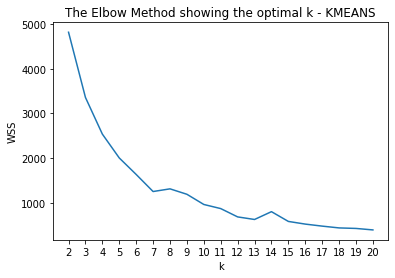

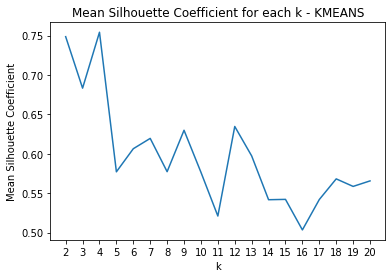

In [115]:
cluster.analyzeK(df_model, 'kmeans')

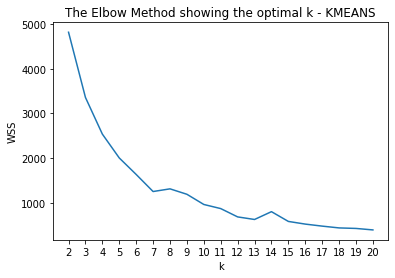

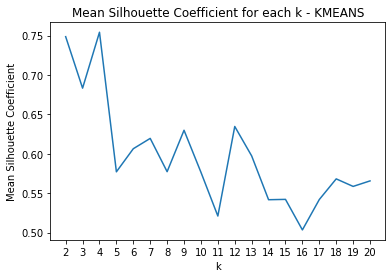

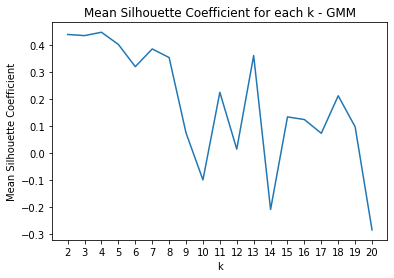

In [116]:
cluster.analyzeK(df_model, ['kmeans', 'gmm'])

In [117]:
trainer = SparkUnsupTrainer()

df_pred = trainer.train(df_model, KMeans).artifacts['model'].transform(df_model)

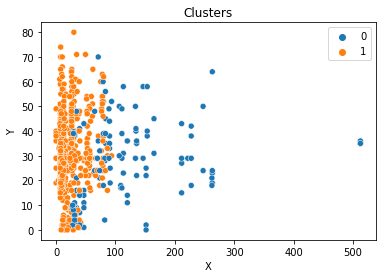

In [124]:
pdf = df_pred.toPandas()
cluster.plot_cluster(pdf, 'Fare' , 'Age', 'prediction')

### PCA

In [125]:
processor = SparkPreprocessor({'robust': ['Age', 'Fare', 'total_relatives']}, input_strategy = 'mean')
df_model = processor.fit_transform(df)

In [127]:
pca = SparkPCA(['Age', 'Fare', 'total_relatives'], k = 2)
pca.fit_transform(df_model).toPandas()

Explained variance (1): 0.42874088467694255
Explained variance (2): 0.3643043298017376


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,robust_scaled,zscore_scaled,cmp_1,cmp_2
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"[-0.5384615384615385, -0.3118134365180357, 1.0]","[-0.5797188207501821, -0.5021631365156044, 0.0...",0.144407,-0.755145
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"[0.6923076923076923, 2.4596869833190502, 1.0]","[0.6497473364373433, 0.7864036178345394, 0.059...",0.022455,1.021556
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"[-0.23076923076923078, -0.28259796920040514, 0.0]","[-0.27235228145330076, -0.4885798515812601, -0...",-0.477253,-0.572371
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"[0.46153846153846156, 1.6726742323906478, 1.0]","[0.41922243196468223, 0.4204940697654103, 0.05...",-0.004584,0.594087
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"[0.46153846153846156, -0.27718769747491795, 0.0]","[0.41922243196468223, -0.4860644284452704, -0....",-0.835839,-0.121157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",Male,27,0,0,211536,13.0000,None,Southampton,0,"[-0.15384615384615385, -0.06294093714562721, 0.0]","[-0.19551064662908044, -0.38645367226007915, -...",-0.476207,-0.444941
887,888,1,1,"Graham, Miss. Margaret Edith",Female,19,0,0,112053,30.0000,B42,Southampton,0,"[-0.7692307692307693, 0.672856017520624, 0.0]","[-0.8102437252228432, -0.044356125765482625, -...",-0.019223,-0.584694
888,889,0,3,"""johnston, Miss. Catherine Helen """"carrie""""""",Female,29,1,2,W./C. 6607,23.4500,None,Southampton,3,"[0.0, 0.3893577791050978, 3.0]","[-0.04182737698063976, -0.17616429809134188, 1...",0.930188,-0.103823
889,890,1,1,"Behr, Mr. Karl Howell",Male,26,0,0,111369,30.0000,C148,Cherbourg,0,"[-0.23076923076923078, 0.672856017520624, 0.0]","[-0.27235228145330076, -0.044356125765482625, ...",-0.298908,-0.235235


In [132]:
pca = SparkPCA(['Age', 'Fare', 'total_relatives'], .9)
pca.fit_transform(df_model).limit(5).toPandas()

Explained variance (1): 0.42874088467694255
Explained variance (2): 0.3643043298017376
Explained variance (3): 0.20695478552131982


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,robust_scaled,zscore_scaled,cmp_1,cmp_2,cmp_3
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"[-0.5384615384615385, -0.3118134365180357, 1.0]","[-0.5797188207501821, -0.5021631365156044, 0.0...",0.144407,-0.755145,0.025293
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"[0.6923076923076923, 2.4596869833190502, 1.0]","[0.6497473364373433, 0.7864036178345394, 0.059...",0.022455,1.021556,0.004085
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"[-0.23076923076923078, -0.28259796920040514, 0.0]","[-0.27235228145330076, -0.4885798515812601, -0...",-0.477253,-0.572371,0.268041
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"[0.46153846153846156, 1.6726742323906478, 1.0]","[0.41922243196468223, 0.4204940697654103, 0.05...",-0.004584,0.594087,-0.055666
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"[0.46153846153846156, -0.27718769747491795, 0.0]","[0.41922243196468223, -0.4860644284452704, -0....",-0.835839,-0.121157,-0.114195


In [131]:
pca = SparkPCA(['Age', 'Fare', 'total_relatives'], input_strategy = 'median')
pca.fit_transform(df_model).limit(5).toPandas()

Explained variance (1): 0.42874088467694255
Explained variance (2): 0.3643043298017376


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,robust_scaled,zscore_scaled,cmp_1,cmp_2
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"[-0.5384615384615385, -0.3118134365180357, 1.0]","[-0.5797188207501821, -0.5021631365156044, 0.0...",0.144407,-0.755145
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"[0.6923076923076923, 2.4596869833190502, 1.0]","[0.6497473364373433, 0.7864036178345394, 0.059...",0.022455,1.021556
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"[-0.23076923076923078, -0.28259796920040514, 0.0]","[-0.27235228145330076, -0.4885798515812601, -0...",-0.477253,-0.572371
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"[0.46153846153846156, 1.6726742323906478, 1.0]","[0.41922243196468223, 0.4204940697654103, 0.05...",-0.004584,0.594087
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"[0.46153846153846156, -0.27718769747491795, 0.0]","[0.41922243196468223, -0.4860644284452704, -0....",-0.835839,-0.121157


### Feature Selection

In [147]:
processor = SparkPreprocessor({'zscore': ['Age', 'Fare', 'total_relatives']}, ['Sex', 'Pclass'], input_strategy = 'mean')
df_model = processor.fit_transform(df)

In [148]:
df_model.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Sex_ohe,Pclass_ohe,zscore_scaled,features
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[-0.5797188207501821, -0.5021631365156044, 0.0...","[1.0, 0.0, 1.0, 0.0, 0.0, -0.5797188207501821,..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.6497473364373433, 0.7864036178345394, 0.059...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.6497473364373433, ..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(0.0, 1.0)","(1.0, 0.0, 0.0)","[-0.27235228145330076, -0.4885798515812601, -0...","[0.0, 1.0, 1.0, 0.0, 0.0, -0.27235228145330076..."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.41922243196468223, 0.4204940697654103, 0.05...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.41922243196468223,..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[0.41922243196468223, -0.4860644284452704, -0....","[1.0, 0.0, 1.0, 0.0, 0.0, 0.41922243196468223,..."


In [170]:
mapping = {
    'continuous': {
        'selectionMode': 'fpr',
        'selectionThreshold': 0.05,
        'cols': ['zscore_scaled']
    },
    'categorical': {
        'selectionMode': 'numTopFeatures', 
        'selectionThreshold': 3,
        'cols': ['Sex_ohe', 'Pclass_ohe']
    }
}

In [171]:
selector = SparkFS(mapping, 'Survived', 'categorical')
selector.transform(df_model).limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,total_relatives,Sex_ohe,Pclass_ohe,zscore_scaled,features,selected_features
0,1,0,3,"Braund, Mr. Owen Harris",Male,22,1,0,A/5 21171,7.2500,None,Southampton,1,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[-0.5797188207501821, -0.5021631365156044, 0.0...","[1.0, 0.0, 1.0, 0.0, 0.0, -0.5797188207501821,...","[-0.5797188207501821, -0.5021631365156044, 1.0..."
1,2,1,1,"Cumings, Mrs. John Bradley (florence Briggs Th...",Female,38,1,0,PC 17599,71.2833,C85,Cherbourg,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.6497473364373433, 0.7864036178345394, 0.059...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.6497473364373433, ...","[0.6497473364373433, 0.7864036178345394, 0.0, ..."
2,3,1,3,"Heikkinen, Miss. Laina",Female,26,0,0,STON/O2. 3101282,7.9250,None,Southampton,0,"(0.0, 1.0)","(1.0, 0.0, 0.0)","[-0.27235228145330076, -0.4885798515812601, -0...","[0.0, 1.0, 1.0, 0.0, 0.0, -0.27235228145330076...","[-0.27235228145330076, -0.4885798515812601, 0...."
3,4,1,1,"Futrelle, Mrs. Jacques Heath (lily May Peel)",Female,35,1,0,113803,53.1000,C123,Southampton,1,"(0.0, 1.0)","(0.0, 1.0, 0.0)","[0.41922243196468223, 0.4204940697654103, 0.05...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.41922243196468223,...","[0.41922243196468223, 0.4204940697654103, 0.0,..."
4,5,0,3,"Allen, Mr. William Henry",Male,35,0,0,373450,8.0500,None,Southampton,0,"(1.0, 0.0)","(1.0, 0.0, 0.0)","[0.41922243196468223, -0.4860644284452704, -0....","[1.0, 0.0, 1.0, 0.0, 0.0, 0.41922243196468223,...","[0.41922243196468223, -0.4860644284452704, 1.0..."
